# A Deep Neural Network Regressor - Rework for TBME

I am using a ConvNet to regress 32 electrode readings into the expected lung volume measurement. Inputs are 32x224 matrices, corresponding to 32 electrodes, with 224 patterns. 

I also include occlusions and elevations as targets. 

In [1]:
%matplotlib inline

#Basic Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random

# Sklearn Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
!ls data9

EITimages.mat  loss_logs_single.csv  testImages.mat	ypred_multi.csv
elec.csv       README(1).docx	     testOccl		ypred_single.csv
getEitImage.m  README.docx	     train.csv		ytest_multi.csv
heartVols.mat  test.csv		     trainElev.csv	ytest_single.csv
iipats.csv     testElev.csv	     trainOccl.csv
loss_logs.csv  testImages	     valid_results.csv


In [4]:
# Make Cyclic By Rolling Over 1st K rows to Edge
cyclic = lambda x, K=4: np.append(x,x[:,:,:K,:,:],axis=2)

In [5]:
# Load Others
def load_data(path,test=False):
    if not test:
        dfile = path + '/train.csv'
        ofile = path + '/trainOccl.csv'
        efile = path + '/trainElev.csv'

        data   = pd.read_csv(dfile,header=None).values
        x_data = data[:,:-1].reshape((11,-1,32,224,1)).transpose(1,0,2,3,4)
        x_data = cyclic(x_data)
        y_data = data[:, -1].reshape((11,-1)).transpose(1,0)

        o_data = pd.read_csv(ofile,header=None).values
        o_data = o_data.reshape((11,-1,32)).transpose(1,0,2)
        
        e_data = pd.read_csv(efile,header=None).values
        e_data = e_data.reshape((11,-1)).transpose(1,0)
        return x_data,y_data,o_data,e_data
    
    else:
        tfile = path + '/test.csv'
        data   = pd.read_csv(tfile,header=None).values
        x_data = data[:,:-1].reshape((11,-1,32,224,1)).transpose(1,0,2,3,4)
        x_data = cyclic(x_data)
        y_data = data[:, -1].reshape((11,-1)).transpose(1,0)
        return x_data,y_data

In [6]:
# Load Data
path  = 'data9'
x_data,l_data,o_data,e_data=load_data(path)

In [7]:
print 'X shape:', x_data.shape
print 'L shape:', l_data.shape
print 'O shape:', o_data.shape
print 'E shape:', e_data.shape

X shape: (7000, 11, 36, 224, 1)
L shape: (7000, 11)
O shape: (7000, 11, 32)
E shape: (7000, 11)


In [8]:
# Scale Data
ysclr  = RobustScaler().fit(l_data.reshape(-1,1))
y_data = ysclr.transform(l_data.reshape(-1,1)).reshape(-1,11)
o_data = o_data/100.
e_data = e_data.squeeze()

In [9]:
x_train,x_valid,\
y_train,y_valid,\
o_train,o_valid,\
e_train,e_valid = train_test_split(x_data,
                                   y_data,
                                   o_data,
                                   e_data,
                                   test_size=0.30,random_state=32)

In [10]:
# Reshaping Back
nshp = (-1,) + x_data.shape[2:]
x_train = x_train.reshape(nshp)
y_train = y_train.reshape(-1)
o_train = o_train.reshape((-1,32))
e_train = e_train.reshape(-1)

x_valid = x_valid.reshape(nshp)
y_valid = y_valid.reshape(-1)
o_valid = o_valid.reshape((-1,32))
e_valid = e_valid.reshape(-1)

print 'X train:', x_train.shape
print 'Y train:', y_train.shape
print 'O train:', o_train.shape
print 'E train:', e_train.shape

X train: (53900, 36, 224, 1)
Y train: (53900,)
O train: (53900, 32)
E train: (53900,)


## Regressor Model

In [11]:
# Keras Imports
from keras.models import Model, load_model
from keras.layers import Input, Dense, Lambda, AveragePooling2D, UpSampling2D
from keras.layers import Flatten, Reshape,Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.advanced_activations import PReLU
from keras import regularizers
from keras import backend as K
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint
from keras.callbacks import TensorBoard

/home/junior/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
## Training Params
num_batch = 32
num_epoch = 80
patience  = 10

# Parameters
# ndim = x_train.shape[1]
npat,ndim,_ = x_train.shape[1:]
L1   = 127
L2   = 169
L3   = 16

In [13]:
# Build DNN
def build_model():
    x = Input(shape=(npat,ndim,1),name='Input')
    h = Conv2D(28,activation='relu',kernel_size=(3,5),strides=(2,3),padding='same',name='L1')(x)
    h = BatchNormalization()(h)
    h = Conv2D(16,activation='relu',kernel_size=(3,3),strides=(2,3),padding='same',name='L2')(h)
    h = BatchNormalization()(h)
    h = Conv2D(15,activation='relu',kernel_size=(3,3),strides=(1,3),padding='same',name='L3')(h)
    h = BatchNormalization()(h)
    h = AveragePooling2D((2,2),strides=(2,2))(h)
    h = Flatten()(h)
    
    
    # Lung Volume
    y = Dense(7,activation='tanh',name='L4')(h)
    y = Dense(1,activation='linear',name='YOutput')(y)
    ymodel = Model(x,y)
    
    # Occlusion
    o = Dense(10,activation='tanh',name='O4')(h)
    o = Dense(32,activation='relu',name='OOutput')(o)
    
    # Elevation
    e = Dense(5,activation='tanh',name='E4')(h)
    e = Dense(1, activation='linear',name='EOutput')(e)
    cmodel = Model(inputs=[x],outputs=[y,o,e])
    
    return ymodel, cmodel

In [14]:
# Compile Model
model,cmodel = build_model()
model.compile(optimizer='adam',loss='mean_squared_error')
cmodel.compile(optimizer='adam', 
               loss=['mean_squared_error','categorical_crossentropy','mean_squared_error'],
               loss_weights=[0.7,0.15,0.15])
cmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 36, 224, 1)   0                                            
__________________________________________________________________________________________________
L1 (Conv2D)                     (None, 18, 75, 28)   448         Input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 18, 75, 28)   112         L1[0][0]                         
__________________________________________________________________________________________________
L2 (Conv2D)                     (None, 9, 25, 16)    4048        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [24]:
# Train
log = cmodel.fit(x_train, [y_train,o_train,e_train],
                batch_size=num_batch,
                epochs=num_epoch,
                shuffle=True,
                validation_data=(x_valid,[y_valid,o_valid,e_valid]))

Train on 53900 samples, validate on 23100 samples
Epoch 1/80
53900/53900 [==============================] - 14s 263us/step - loss: 0.2448 - YOutput_loss: 0.0054 - OOutput_loss: 4.7757 - EOutput_loss: 0.0224 - val_loss: 0.2837 - val_YOutput_loss: 0.0082 - val_OOutput_loss: 5.4921 - val_EOutput_loss: 0.0355
Epoch 2/80
53900/53900 [==============================] - 14s 255us/step - loss: 0.2516 - YOutput_loss: 0.0061 - OOutput_loss: 4.8969 - EOutput_loss: 0.0249 - val_loss: 0.2803 - val_YOutput_loss: 0.0073 - val_OOutput_loss: 5.4406 - val_EOutput_loss: 0.0343
Epoch 3/80
53900/53900 [==============================] - 14s 252us/step - loss: 0.2498 - YOutput_loss: 0.0057 - OOutput_loss: 4.8690 - EOutput_loss: 0.0239 - val_loss: 0.2965 - val_YOutput_loss: 0.0103 - val_OOutput_loss: 5.6987 - val_EOutput_loss: 0.0461
Epoch 4/80
53900/53900 [==============================] - 14s 252us/step - loss: 0.2522 - YOutput_loss: 0.0059 - OOutput_loss: 4.9141 - EOutput_loss: 0.0242 - val_loss: 0.2791 - v

Epoch 33/80
53900/53900 [==============================] - 13s 248us/step - loss: 0.2507 - YOutput_loss: 0.0055 - OOutput_loss: 4.8929 - EOutput_loss: 0.0224 - val_loss: 0.2794 - val_YOutput_loss: 0.0072 - val_OOutput_loss: 5.4242 - val_EOutput_loss: 0.0333
Epoch 34/80
53900/53900 [==============================] - 13s 245us/step - loss: 0.2415 - YOutput_loss: 0.0050 - OOutput_loss: 4.7192 - EOutput_loss: 0.0207 - val_loss: 0.2851 - val_YOutput_loss: 0.0088 - val_OOutput_loss: 5.5038 - val_EOutput_loss: 0.0400
Epoch 35/80
53900/53900 [==============================] - 13s 247us/step - loss: 0.2419 - YOutput_loss: 0.0052 - OOutput_loss: 4.7229 - EOutput_loss: 0.0215 - val_loss: 0.2743 - val_YOutput_loss: 0.0078 - val_OOutput_loss: 5.3126 - val_EOutput_loss: 0.0333
Epoch 36/80
53900/53900 [==============================] - 14s 252us/step - loss: 0.2365 - YOutput_loss: 0.0047 - OOutput_loss: 4.6261 - EOutput_loss: 0.0195 - val_loss: 0.2739 - val_YOutput_loss: 0.0076 - val_OOutput_loss: 5.

Epoch 65/80
53900/53900 [==============================] - 13s 247us/step - loss: 0.2380 - YOutput_loss: 0.0051 - OOutput_loss: 4.6482 - EOutput_loss: 0.0200 - val_loss: 0.2732 - val_YOutput_loss: 0.0090 - val_OOutput_loss: 5.2675 - val_EOutput_loss: 0.0346
Epoch 66/80
53900/53900 [==============================] - 13s 247us/step - loss: 0.2377 - YOutput_loss: 0.0050 - OOutput_loss: 4.6440 - EOutput_loss: 0.0195 - val_loss: 0.2728 - val_YOutput_loss: 0.0078 - val_OOutput_loss: 5.2847 - val_EOutput_loss: 0.0324
Epoch 67/80
53900/53900 [==============================] - 13s 248us/step - loss: 0.2326 - YOutput_loss: 0.0046 - OOutput_loss: 4.5522 - EOutput_loss: 0.0178 - val_loss: 0.2731 - val_YOutput_loss: 0.0069 - val_OOutput_loss: 5.3085 - val_EOutput_loss: 0.0294
Epoch 68/80
53900/53900 [==============================] - 13s 246us/step - loss: 0.2361 - YOutput_loss: 0.0051 - OOutput_loss: 4.6092 - EOutput_loss: 0.0207 - val_loss: 0.2705 - val_YOutput_loss: 0.0069 - val_OOutput_loss: 5.

In [31]:
# model.save('multitask_net.h5')

In [ ]:
# model = load_model('trainednet.h5')

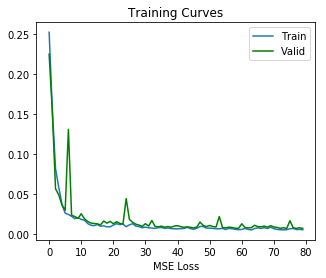

In [17]:
# Training Curves
plt.figure(figsize=(5,4))
plt.plot(log.epoch,log.history['YOutput_loss'])
plt.plot(log.epoch,log.history['val_YOutput_loss'],'g')
plt.title('Training Curves')
plt.xlabel('Epochs')
plt.xlabel('MSE Loss')
plt.legend(['Train','Valid']);

## Testing

In [18]:
rmse = lambda x,y : np.sqrt(np.mean((x-y)**2))

In [25]:
# Generate Predictions for Test Set
x_test,y_test = load_data(path,test=True)
x_test = x_test.reshape(nshp)

In [26]:
y_pred = model.predict(x_test)
y_pred = ysclr.inverse_transform(y_pred).reshape(-1,11)

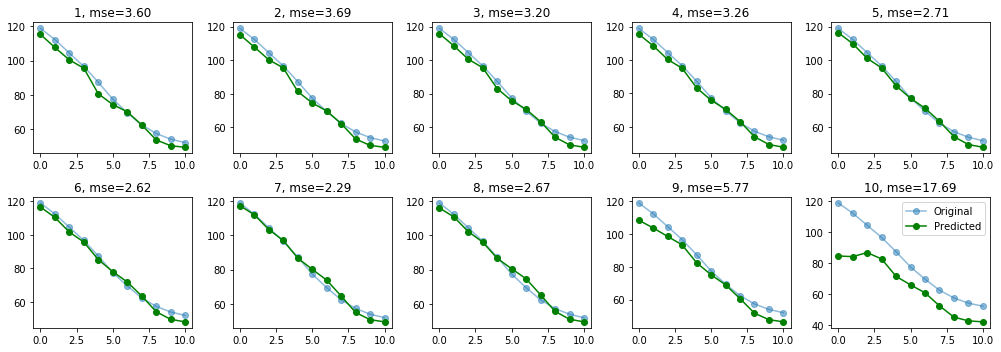

In [29]:
# Plot Test Examples
row = 2
col = 5

plt.figure(figsize=(14,5));
for i, (yt,yp) in enumerate(zip(y_test,y_pred)):
    plt.subplot(row,col,i+1)
    plt.plot(yt,'o-',label='Pred',alpha=0.5);
    plt.plot(yp,'go-',label='True');
    mse = rmse(yp,yt)
    header = '{0}, mse={1:.02f}'.format(i+1,mse)
    plt.title(header);

plt.legend(['Original','Predicted'],loc=1)
plt.tight_layout()

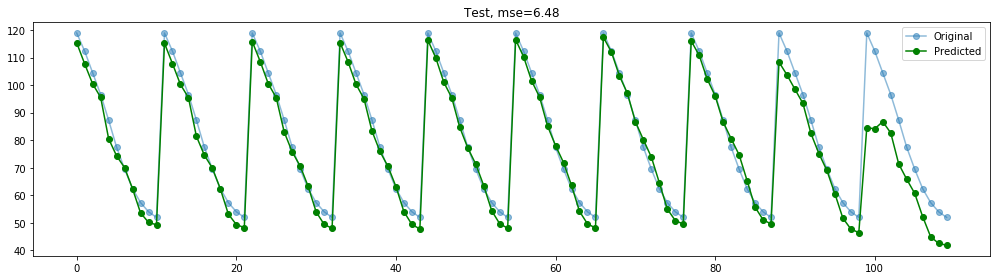

In [30]:
# Plot Results
plt.figure(figsize=(14,4))
plt.subplot(111)
plt.plot(y_test.flatten(),'o-',alpha=0.5)
plt.plot(y_pred.flatten(),'go-')
mse = rmse(y_pred,y_test)
header = 'Test, mse={0:.02f}'.format(mse)
plt.title(header)

plt.legend(['Original','Predicted'],loc=1)
plt.tight_layout()

----

In [23]:
# Save Values
oname = path + '/ypred_multi.csv'
tname = path + '/ytest_multi.csv'
np.savetxt(oname,y_pred,delimiter=',')
np.savetxt(tname,y_test,delimiter=',')